In [1]:
import os
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
from torchvision import transforms, models
from torchvision.transforms import functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

/home/kaiwei/miniconda3/envs/cogvlm-demo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset and preprocessing

### 1. Define the dataset

In [2]:
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images (e.g., 'A/B/C').
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []

        label_numeric = {
            "no": 0,
            "sphere": 1,
            "vort": 2
        }

        for label_dir in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_dir)
            for filename in os.listdir(label_path):
                self.filepaths.append(os.path.join(label_path, filename))
                self.labels.append(label_numeric[label_dir])

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.filepaths[idx]
        image = np.load(img_path)
        image = torch.from_numpy(image).float()
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### 2. Define customized transformer with Min-Max normalization
Two additional channels are added to enhance the asymmetric part in the image \
&nbsp;&nbsp;Channels 0: F(x,y) \
&nbsp;&nbsp;Channels 1: F(x,y)-F(-x,-y) \
&nbsp;&nbsp;Channels 2: F(x,y)+F(-x,-y)-F(-y,x)-F(y,-x)


In [3]:
class CustomTransformNoScale:
    def __call__(self, x):
        # x is a PyTorch tensor of the image

        # Ensure image is in the expected format [C, H, W]
        if x.ndim == 2:  # If the image is grayscale, unsqueeze to add a channel dimension
            x = x.unsqueeze(0)

        x = F.resize(x, [224, 224])
        
        # Step 1: Rotate the image by 180 degrees
        rotated_image = F.rotate(x, 180)

        # Step 2: Subtract the rotated image from the original
        subtracted_image = torch.sub(x, rotated_image)

        # Step 3: Rescale the subtracted result to the 0-1 scale
        subtracted_image = subtracted_image - subtracted_image.min()
        subtracted_image = subtracted_image / subtracted_image.max()

        # Step 4: Make central reflection
        R90_image = F.rotate(x,90)
        R270_image = F.rotate(x, 270)

        # Step 5: Rescale the subtracted result to the 0-255 range
        quad_image = torch.add(x, rotated_image)
        quad_image = torch.sub(quad_image, R90_image)
        quad_image = torch.sub(quad_image, R270_image)
        quad_image = quad_image - quad_image.min()
        quad_image = quad_image / quad_image.max()

        # Ensure the subtracted_image has the same dimensions as the input, for grayscale images
        if subtracted_image.ndim == 2:
            subtracted_image = subtracted_image.unsqueeze(0)

        # Step 4: Append the rescaled result as a new channel to the input image
        result_image = torch.cat((x, subtracted_image, quad_image), dim=0)  # Assuming x is [C, H, W]
    
        angle = random.randint(-180, 180)
        result_image = F.rotate(result_image, angle)
        
        return result_image

In [4]:
drive_dir = "./"
train_dir = f'{drive_dir}/dataset/train'  # Change this path to your dataset's root directory
dataset_fortrain = LensDataset(train_dir, transform=CustomTransformNoScale())
dataloader_train = DataLoader(dataset_fortrain, batch_size=32)

### 3. Calculate the Standardization variables 

In [5]:
def compute_mean_std(loader):
    # Variables to accumulate the sum of all pixels in each channel
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for images, _ in loader:
        channels_sum += torch.mean(images, dim=[0,2,3])
        channels_squared_sum += torch.mean(images**2, dim=[0,2,3])
        num_batches += 1
    # Compute mean and std dev
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# Calculate mean and standard deviation
mean, std = compute_mean_std(dataloader_train)

In [6]:
print(mean, std)

tensor([0.0603, 0.4415, 0.4415]) tensor([0.1175, 0.1744, 0.1810])


### 4. Create the customized transform with Standardization

In [12]:
class CustomTransform:
    def __call__(self, x):
        # x is a PyTorch tensor of the image

        # Ensure image is in the expected format [C, H, W]
        if x.ndim == 2:  # If the image is grayscale, unsqueeze to add a channel dimension
            x = x.unsqueeze(0)

        x = F.resize(x, [224, 224])
        
        # Step 1: Rotate the image by 180 degrees
        rotated_image = F.rotate(x, 180)

        # Step 2: Subtract the rotated image from the original
        subtracted_image = torch.sub(x, rotated_image)

        # Step 3: Rescale the subtracted result to the 0-255 range
        subtracted_image = subtracted_image - subtracted_image.min()
        subtracted_image = subtracted_image / subtracted_image.max()

        # Step 4: Make central reflection
        R90_image = F.rotate(x,90)
        R270_image = F.rotate(x, 270)

        # Step 5: Rescale the subtracted result to the 0-255 range
        quad_image = torch.add(x, rotated_image)
        quad_image = torch.sub(quad_image, R90_image)
        quad_image = torch.sub(quad_image, R270_image)
        quad_image = quad_image - quad_image.min()
        quad_image = quad_image / quad_image.max()

        # Ensure the subtracted_image has the same dimensions as the input, for grayscale images
        if subtracted_image.ndim == 2:
            subtracted_image = subtracted_image.unsqueeze(0)

        # Step 4: Append the rescaled result as a new channel to the input image
        result_image = torch.cat((x, subtracted_image, quad_image), dim=0)  # Assuming x is [C, H, W]
    
        mean = [0.0603, 0.4412, 0.4412]
        std = [0.1175, 0.1747, 0.1813]
        result_image = F.normalize(result_image, mean=mean, std=std)

        angle = random.randint(-180, 180)
        result_image = F.rotate(result_image, angle)
        
        return result_image


# Helper functions

In [13]:
def load_dataset():
    # Usage
    drive_dir = "./"
    train_dir = f'{drive_dir}/dataset/train'  # Change this path to your dataset's root directory

    dataset_fortrain = LensDataset(train_dir, transform=CustomTransform())
    total_fortrain = len(dataset_fortrain)


    train_len = int(total_fortrain * 0.9)
    val_len = total_fortrain - train_len

    dataset_train, dataset_val = random_split(dataset_fortrain, [train_len, val_len])

    
    #dataset_train = LensDataset(train_dir, transform=transform)
    sampler_train = RandomSampler(dataset_train)
    sampler_val = RandomSampler(dataset_val)

    dataloader_train = DataLoader(dataset_train, batch_size=32, sampler=sampler_train)
    dataloader_val = DataLoader(dataset_val, batch_size=32, sampler=sampler_val)

    
    test_dir = f'{drive_dir}/dataset/val'  # Change this path to your dataset's root directory
    dataset_test = LensDataset(test_dir, transform=CustomTransform())
    #dataset_val = LensDataset(val_dir, transform=transform)
    sampler_test = RandomSampler(dataset_test)
    dataloader_test = DataLoader(dataset_test, batch_size=32, sampler=sampler_test)

    # Class names for CIFAR-10 dataset
    classes = ("no", "sphere", "vort")

    return dataset_train, dataloader_train, dataset_val, dataloader_val, dataset_test, dataloader_test, classes

In [14]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    # Switch to train mode
    model.train()
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Compute average training loss and accuracy
    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item() * inputs.size(0)

            # Compute test accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Compute average test loss and accuracy
    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy

def train_epochs(model, trainloader, valloader, criterion, optimizer, scheduler, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = test(model, valloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%')
        print()

        if (epoch + 1) % save_interval == 0:
          # Save the model and variables
          torch.save(model.state_dict(), f'resnet50_lense_{epoch+1}.pth')
          checkpoint = {
              'epoch': epoch + 1,
              'train_losses': train_losses,
              'train_accuracies': train_accuracies,
              'val_losses': val_losses,
              'val_accuracies': val_accuracies,
              'classes': classes
          }
          torch.save(checkpoint, f'resnet50_lense_variables_{epoch+1}.pth')

    return model, train_losses, train_accuracies, val_losses,val_accuracies


In [15]:
import matplotlib.pyplot as plt
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()
def plot_image(dataset, model, classes):
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    img = dataset[idx][0].unsqueeze(0).to(device)  # Move the input image tensor to the GPU
    model.eval()
    #model.to(device)  # Move the model to the GPU
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    # Convert the image and show it
    img = img.squeeze().permute(1, 2, 0).cpu()  # Move the image tensor back to the CPU and adjust dimensions
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    plt.savefig('predicted_image.png')
    plt.show()
    print("Predicted label: ", classes[predicted[0].item()])
    print("Actual label: ", classes[label])

# Model training

ResNet50 is used as baseline model and pre-trained weight is used to accelerate the fine-tuning procedure.
The training procedure followes the method described in the previous paper https://arxiv.org/pdf/1909.07346.pdf

Epoch 1/30


100%|██████████| 94/94 [00:36<00:00,  2.59it/s]


Train Loss: 1.0354 - Train Accuracy: 42.87%
Val Loss: 1.0214 - Val Accuracy: 50.67%

Epoch 2/30


100%|██████████| 94/94 [00:50<00:00,  1.86it/s]


Train Loss: 0.7351 - Train Accuracy: 66.70%
Val Loss: 0.6076 - Val Accuracy: 74.00%

Epoch 3/30


100%|██████████| 94/94 [00:44<00:00,  2.13it/s]


Train Loss: 0.5626 - Train Accuracy: 76.30%
Val Loss: 0.4903 - Val Accuracy: 80.67%

Epoch 4/30


100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Train Loss: 0.4747 - Train Accuracy: 80.78%
Val Loss: 0.4511 - Val Accuracy: 82.20%

Epoch 5/30


100%|██████████| 94/94 [00:46<00:00,  2.04it/s]


Train Loss: 0.4137 - Train Accuracy: 83.59%
Val Loss: 0.3820 - Val Accuracy: 85.60%

Epoch 6/30


100%|██████████| 94/94 [00:35<00:00,  2.68it/s]


Train Loss: 0.3653 - Train Accuracy: 85.85%
Val Loss: 0.3493 - Val Accuracy: 87.13%

Epoch 7/30


100%|██████████| 94/94 [00:35<00:00,  2.63it/s]


Train Loss: 0.3309 - Train Accuracy: 87.21%
Val Loss: 0.3057 - Val Accuracy: 88.43%

Epoch 8/30


100%|██████████| 94/94 [00:35<00:00,  2.67it/s]


Train Loss: 0.2971 - Train Accuracy: 88.88%
Val Loss: 0.3000 - Val Accuracy: 89.00%

Epoch 9/30


100%|██████████| 94/94 [00:35<00:00,  2.66it/s]


Train Loss: 0.2763 - Train Accuracy: 89.49%
Val Loss: 0.2935 - Val Accuracy: 89.00%

Epoch 10/30


100%|██████████| 94/94 [00:35<00:00,  2.67it/s]


Train Loss: 0.2554 - Train Accuracy: 90.39%
Val Loss: 0.2433 - Val Accuracy: 91.10%

Epoch 11/30


100%|██████████| 94/94 [00:35<00:00,  2.66it/s]


Train Loss: 0.2381 - Train Accuracy: 91.15%
Val Loss: 0.2472 - Val Accuracy: 91.20%

Epoch 12/30


100%|██████████| 94/94 [00:43<00:00,  2.14it/s]


Train Loss: 0.2264 - Train Accuracy: 91.75%
Val Loss: 0.2354 - Val Accuracy: 91.70%

Epoch 13/30


100%|██████████| 94/94 [00:50<00:00,  1.87it/s]


Train Loss: 0.2164 - Train Accuracy: 92.03%
Val Loss: 0.2650 - Val Accuracy: 90.63%

Epoch 14/30


100%|██████████| 94/94 [00:35<00:00,  2.65it/s]


Train Loss: 0.2070 - Train Accuracy: 92.46%
Val Loss: 0.2092 - Val Accuracy: 92.90%

Epoch 15/30


100%|██████████| 94/94 [00:40<00:00,  2.31it/s]


Train Loss: 0.1993 - Train Accuracy: 92.86%
Val Loss: 0.2112 - Val Accuracy: 92.33%

Epoch 16/30


100%|██████████| 94/94 [00:47<00:00,  1.99it/s]


Train Loss: 0.1906 - Train Accuracy: 92.99%
Val Loss: 0.1904 - Val Accuracy: 92.80%

Epoch 17/30


100%|██████████| 94/94 [00:49<00:00,  1.92it/s]


Train Loss: 0.1796 - Train Accuracy: 93.44%
Val Loss: 0.1982 - Val Accuracy: 92.97%

Epoch 18/30


100%|██████████| 94/94 [00:51<00:00,  1.84it/s]


Train Loss: 0.1748 - Train Accuracy: 93.69%
Val Loss: 0.1917 - Val Accuracy: 93.53%

Epoch 19/30


100%|██████████| 94/94 [00:48<00:00,  1.95it/s]


Train Loss: 0.1670 - Train Accuracy: 93.93%
Val Loss: 0.1959 - Val Accuracy: 93.57%

Epoch 20/30


100%|██████████| 94/94 [00:44<00:00,  2.09it/s]


Train Loss: 0.1635 - Train Accuracy: 94.07%
Val Loss: 0.1920 - Val Accuracy: 93.10%

Epoch 21/30


100%|██████████| 94/94 [00:45<00:00,  2.05it/s]


Train Loss: 0.1572 - Train Accuracy: 94.24%
Val Loss: 0.1897 - Val Accuracy: 93.47%

Epoch 22/30


100%|██████████| 94/94 [00:46<00:00,  2.02it/s]


Train Loss: 0.1538 - Train Accuracy: 94.62%
Val Loss: 0.1717 - Val Accuracy: 93.70%

Epoch 23/30


100%|██████████| 94/94 [00:45<00:00,  2.07it/s]


Train Loss: 0.1504 - Train Accuracy: 94.49%
Val Loss: 0.1798 - Val Accuracy: 93.53%

Epoch 24/30


100%|██████████| 94/94 [00:48<00:00,  1.95it/s]


Train Loss: 0.1480 - Train Accuracy: 94.63%
Val Loss: 0.1746 - Val Accuracy: 94.03%

Epoch 25/30


100%|██████████| 94/94 [00:48<00:00,  1.95it/s]


Train Loss: 0.1442 - Train Accuracy: 94.79%
Val Loss: 0.1771 - Val Accuracy: 93.93%

Epoch 26/30


100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


Train Loss: 0.1408 - Train Accuracy: 94.94%
Val Loss: 0.1754 - Val Accuracy: 94.10%

Epoch 27/30


100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


Train Loss: 0.1399 - Train Accuracy: 95.06%
Val Loss: 0.1636 - Val Accuracy: 94.67%

Epoch 28/30


100%|██████████| 94/94 [00:47<00:00,  1.98it/s]


Train Loss: 0.1349 - Train Accuracy: 95.16%
Val Loss: 0.1758 - Val Accuracy: 94.07%

Epoch 29/30


100%|██████████| 94/94 [00:47<00:00,  1.97it/s]


Train Loss: 0.1304 - Train Accuracy: 95.22%
Val Loss: 0.1853 - Val Accuracy: 93.00%

Epoch 30/30


100%|██████████| 94/94 [00:44<00:00,  2.10it/s]


Train Loss: 0.1317 - Train Accuracy: 95.29%
Val Loss: 0.1555 - Val Accuracy: 94.57%



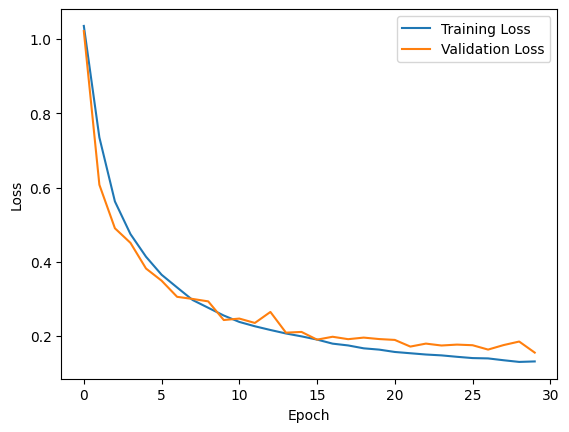

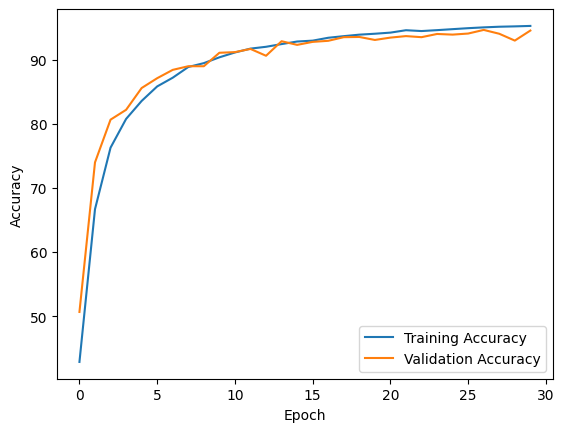

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


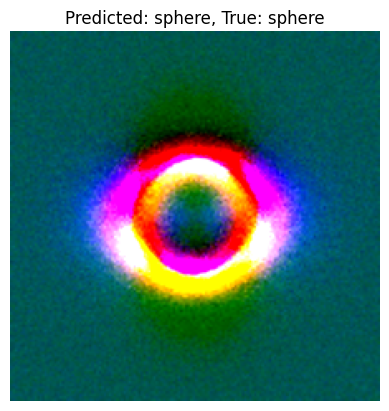

Predicted label:  sphere
Actual label:  sphere


In [20]:
if True:
    torch.cuda.empty_cache()
    train_model = True
    # Set random seed for reproducibilnmity
    random_seed = 42
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Number of classes
    num_classes = 3

    # Import ResNet50 model pretrained on ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    #print("Network before modifying conv1:")
    #print(model)

    # Modify the final fully connected layer according to the number of classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    #print("Network after modifying conv1:")
    #print(model)

    # Move the model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

    # Load the dataset
    trainset, trainloader, valset, valloader, testset, testloader, classes = load_dataset()

    num_epochs = 30
    if train_model:
      # Train the model for 30 epochs, saving every 5 epochs
      save_interval = 5
      model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
          model, trainloader, valloader, criterion, optimizer, scheduler, device,
          num_epochs, save_interval)

      # Save the final trained model
      torch.save(model.state_dict(), f'resnet50_lense_final_model_epochs_{num_epochs}.pth')

      # Plot and save the loss and accuracy plots
      plot_loss(train_losses, val_losses)
      plot_accuracy(train_accuracies, val_accuracies)
        
    # Plot and save an example image
    plot_image(testset, model, classes)

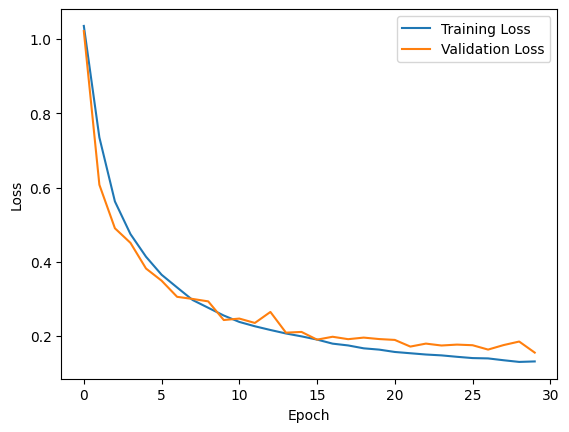

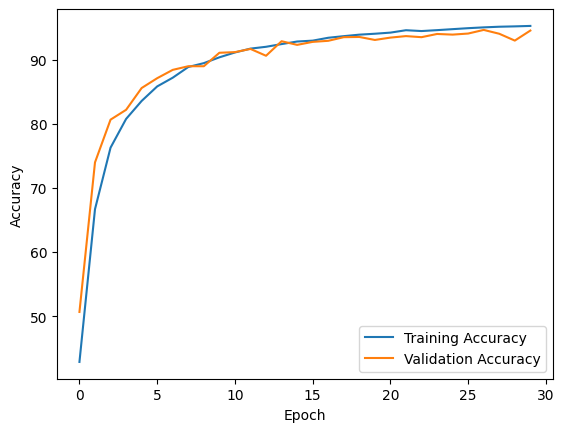

In [21]:
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

# Model inference

In [29]:
model.load_state_dict(torch.load('resnet50_lense_final_model_epochs_30.pth'))
checkpoint = torch.load("resnet50_lense_variables_30.pth")
epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
train_accuracies = checkpoint['train_accuracies']
test_losses = checkpoint['val_losses']
test_accuracies = checkpoint['val_accuracies']
classes = checkpoint['classes']
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
from  torch.nn.functional import softmax
test_loss = 0.0
test_total = 0
test_correct = 0

test_prop = []
test_label = []

with torch.no_grad():
    for inputs, labels in tqdm(testloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Update test loss
        test_loss += loss.item() * inputs.size(0)

        probabilities = softmax(outputs, dim=1)
        test_prop.append(probabilities)
        test_label.append(labels)

        # Compute test accuracy
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Compute average test loss and accuracy
test_loss = test_loss / len(testloader.dataset)
test_accuracy = 100.0 * test_correct / test_total
print("Test loss:", test_loss)
print("Test Accuracy:", test_accuracy)

100%|██████████| 235/235 [01:51<00:00,  2.12it/s]

Test loss: 0.15058418436845145
Test Accuracy: 94.69333333333333


/tmp/ipykernel_148536/3119172963.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


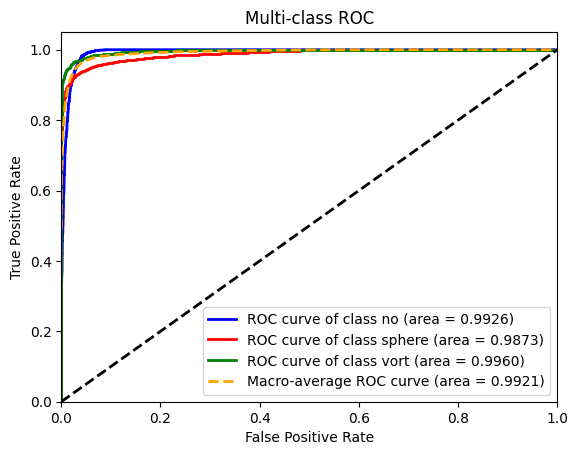

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming y_test are your true class labels and y_score are the predicted probabilities

y_test = []
y_score = []

for item in test_prop:
    y_score += item.detach().cpu().tolist()
for item in test_label:
    y_test += item.detach().cpu().tolist()

y_test = np.array(y_test)
y_score = np.array(y_score)

# Binarize the output classes for one-vs-all computation
n_classes = y_score.shape[1] # Assuming y_score is shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(classes[i], roc_auc[i]))
    
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.4f})'.format(roc_auc["macro"]),
         color='orange', linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig("Multi-class_ROC.png")
plt.show()
